# Fitbit Identifier

- Steven Garis & Matthew Capper

## Imports

In [1]:
# import zgulde.extend_pandas
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
from scipy import stats
from sklearn import metrics

import itertools

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams


%matplotlib inline


from fbprophet import Prophet



# ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Functions

In [2]:
# Used to get more datetime fields to work with.
def expand_dt(df):
    df['time'] = df.index
    df['year'] = df.time.dt.year
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['day_of_month'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_name().str[:3]
    df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) > 4)
    df.drop(columns=['time'], inplace=True)
    return df



## Data Acquisition

- CSVs were provided with the thumb drive

In [3]:
# Making each csv a DataFrame that is split on new line

a = 'fitbit/2018-04-26_through_2018-05-26.csv'
b = 'fitbit/2018-05-27_through_2018-06-26.csv'
c = 'fitbit/2018-06-27_through_2018-07-27.csv'
d = 'fitbit/2018-07-28_through_2018-08-26.csv'
e = 'fitbit/2018-08-27_through_2018-09-26.csv'
g = 'fitbit/2018-09-27_through_2018-10-27.csv'
h = 'fitbit/2018-10-28_through-2018-11-27.csv'
i = 'fitbit/2018-11-28_through_2018-12-28.csv'

FILE = a
with open(FILE) as f:
    contents = f.read()
a = contents.split('\n')
a = pd.DataFrame(a)

FILE = b
with open(FILE) as f:
    contents = f.read()
b = contents.split('\n')
b = pd.DataFrame(b)

FILE = c
with open(FILE) as f:
    contents = f.read()
c = contents.split('\n')
c = pd.DataFrame(c)

FILE = d
with open(FILE) as f:
    contents = f.read()
d = contents.split('\n')
d = pd.DataFrame(d)

FILE = e
with open(FILE) as f:
    contents = f.read()
e = contents.split('\n')
e = pd.DataFrame(e)

FILE = g
with open(FILE) as f:
    contents = f.read()
g = contents.split('\n')
g = pd.DataFrame(g)

FILE = h
with open(FILE) as f:
    contents = f.read()
h = contents.split('\n')
h = pd.DataFrame(h)

FILE = i
with open(FILE) as f:
    contents = f.read()
i = contents.split('\n')
i = pd.DataFrame(i)


## Data Preparation

In [4]:
# Grabbing just the Activities section. All the other sections were filled with a 0.
a = a.iloc[35:67]
b = b.iloc[36:67]
c = c.iloc[36:67]
d = d.iloc[35:65]
e = e.iloc[36:67]
g = g.iloc[36:67]
h = h.iloc[36:67]
i = i.iloc[36:45]

# Combining them in order of the date 
df = a.append(b).append(c).append(d).append(e).append(g).append(h).append(i)
df = df.reset_index()


In [5]:
# Splitting into columns 
df = df[0].str.split('","', expand=True)

# Renaming the colums
df.rename(columns={0: 'date', 
                   1: 'calories_burned', 
                   2: 'steps', 
                   3: 'distance',
                   4: 'floors',
                   5: 'minutes_sedentary',
                   6: 'minutes_lightly_active',
                   7: 'minutes_fairly_active',
                   8: 'minutes_very_active',
                   9: 'activity_calories'}, inplace=True)

# Dropping the old columns names that could't split.
df.drop(index=0, inplace=True)

# Removing the '"' that got left over
df['activity_calories'] = df.activity_calories.str.replace('"','')
df['date'] = df.date.str.replace('"','')

# Removing ',' from numbers
df["calories_burned"] = df.calories_burned.str.replace(',','')
df["steps"] = df.steps.str.replace(',','')
df["minutes_sedentary"] = df.minutes_sedentary.str.replace(',','')
df["activity_calories"] = df.activity_calories.str.replace(',','')

# Setting date to datetime and setting as index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)


# Getting a list of columns
columns = df.columns

# Converting from object to numeric
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

# Expanding DT 
df = expand_dt(df)

#### Checking the prep:

- We have all the dates from the min to max but...
- We are missing dates from 2018-12-07 to 2018-12-28
- There are no missing values

In [6]:
print('Total days: ', df.index.nunique())
print('Start date: ',df.index.min())
print('End date  : ',df.index.max())

Total days:  225
Start date:  2018-04-26 00:00:00
End date  :  2018-12-06 00:00:00


In [7]:
# Checking to see if there are missing dates from min to max

timedelta(df.index.nunique()) == (df.index.max() - df.index.min()) + timedelta(days=1)


True

In [8]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
year                        int64
quarter                     int64
month                       int64
day_of_month                int64
day_of_week                object
is_weekend                   bool
dtype: object

In [9]:
df.isnull().sum()

calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
year                      0
quarter                   0
month                     0
day_of_month              0
day_of_week               0
is_weekend                0
dtype: int64

In [10]:
df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month,day_of_week,is_weekend
date,,,,,,,,,,,,,,,
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305,2018,4,12,2,Sun,True
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993,2018,4,12,3,Mon,False
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663,2018,4,12,4,Tue,False
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,2018,4,12,5,Wed,False
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,2018,4,12,6,Thu,False


## Data Exploration

In [11]:
df.index.max() - timedelta(weeks=4)

Timestamp('2018-11-08 00:00:00', freq='D')

In [12]:
train = df[:'2018-11-08']
test = df['2018-11-08':]



# aggregation = 'mean'
# train = df[:'2018-11-08'].resample('M').agg(aggregation)
# test = df['2018-11-08':].resample('M').agg(aggregation)



In [13]:
train.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.0,197.000000,197.000000,197.000000
mean,3352.994924,7859.944162,3.711574,9.994924,835.096447,180.629442,14.401015,30.040609,1402.350254,2018.0,2.862944,7.553299,15.685279
std,638.501302,5065.369218,2.395296,19.361359,246.743248,75.324128,15.368487,35.503785,738.788103,0.0,0.718912,1.885349,9.102726
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2018.0,2.000000,4.000000,1.000000
25%,3043.000000,4446.000000,2.100000,2.000000,674.000000,152.000000,2.000000,0.000000,999.000000,2018.0,2.000000,6.000000,8.000000
50%,3348.000000,7034.000000,3.320000,6.000000,773.000000,196.000000,10.000000,13.000000,1388.000000,2018.0,3.000000,8.000000,16.000000
75%,3719.000000,11061.000000,5.220000,11.000000,907.000000,232.000000,20.000000,56.000000,1817.000000,2018.0,3.000000,9.000000,24.000000
max,5199.000000,21302.000000,10.050000,162.000000,1440.000000,349.000000,78.000000,125.000000,3596.000000,2018.0,4.000000,11.000000,31.000000


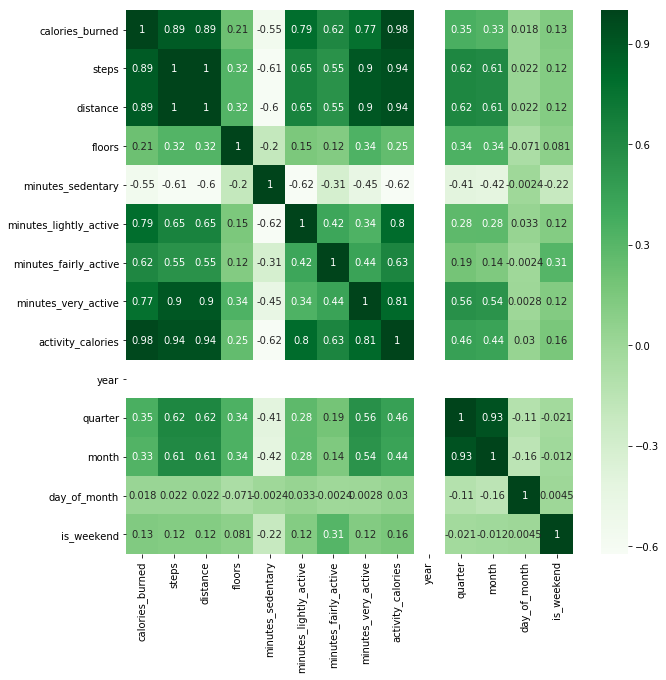

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(data=train.corr(), annot=True, cmap='Greens')

In [15]:
df.groupby('day_of_week')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
day_of_week,,,,
Fri,3464.718750,8847.250000,4.180625,11.062500
Mon,3242.750000,7245.406250,3.439688,6.718750
Sat,3553.187500,9549.656250,4.591563,13.562500
Sun,3551.468750,9904.500000,4.669062,21.843750
Thu,3425.939394,8748.636364,4.157576,12.545455
Tue,3304.093750,7856.875000,3.702813,11.250000
Wed,3270.468750,7594.343750,3.582812,11.156250


In [16]:
# Looks like they are mostly active on the weekends

df.groupby('is_weekend')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
is_weekend,,,,
False,3342.118012,8062.788820,3.814845,10.559006
True,3552.328125,9727.078125,4.630312,17.703125


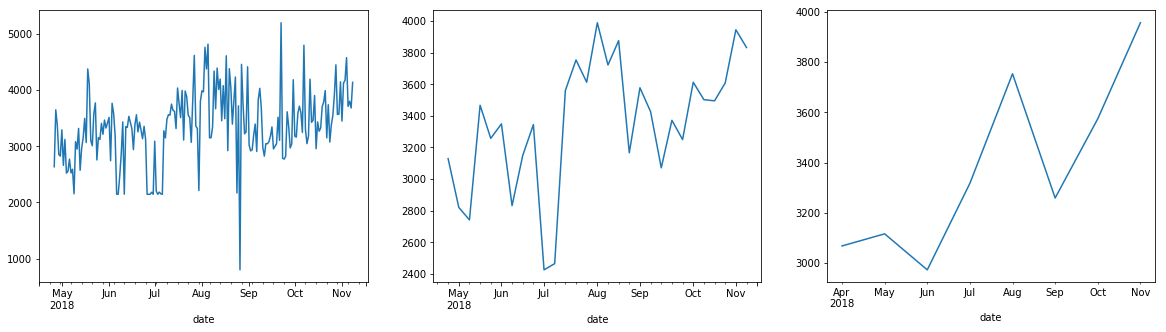

In [17]:
# sns.tsplot or sns.lineplot
plt.figure(figsize=(20,5))

plt.subplot(131)
train.resample('D').calories_burned.mean().plot()

plt.subplot(132)
train.resample('W').calories_burned.mean().plot()

plt.subplot(133)
train.resample('M').calories_burned.mean().plot()


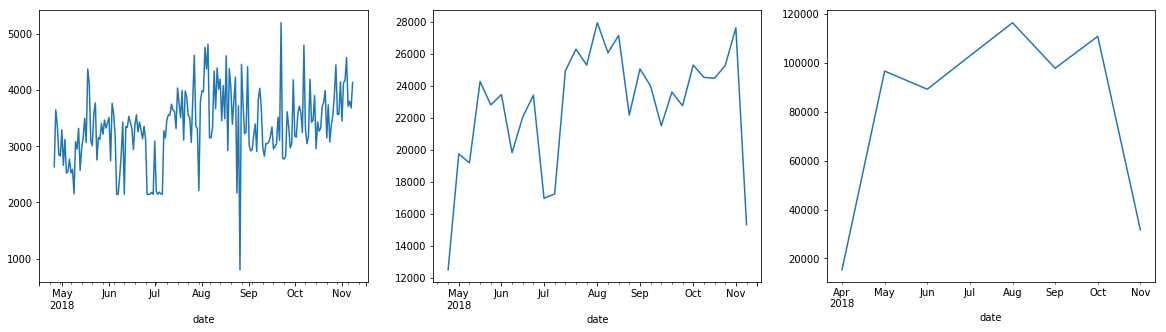

In [18]:
plt.figure(figsize=(20,5))

plt.subplot(131)
train.resample('D').calories_burned.sum().plot()

plt.subplot(132)
train.resample('W').calories_burned.sum().plot()

plt.subplot(133)
train.resample('M').calories_burned.sum().plot()


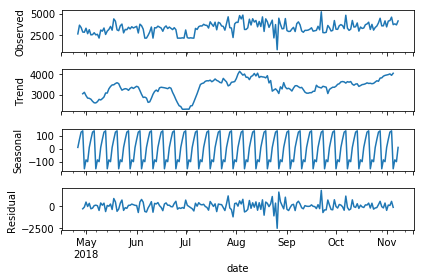

In [19]:
cal_burn = train.resample('D').calories_burned.mean()

decomposition = sm.tsa.seasonal_decompose(cal_burn, model='additive')
fig = decomposition.plot()


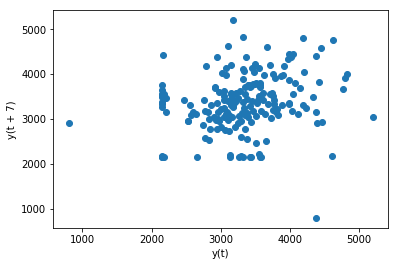

In [20]:
pd.plotting.lag_plot(cal_burn, lag=7)

In [21]:
df_corr = pd.concat([cal_burn, cal_burn.shift(7)], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)


          t-1       t+1
t-1  1.000000  0.206844
t+1  0.206844  1.000000


In [22]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [46]:
aggregation = 'mean'
train = df[:'2018-11-08'].calories_burned.resample('D').agg(aggregation)

test = df['2018-11-08':].calories_burned.resample('D').agg(aggregation)

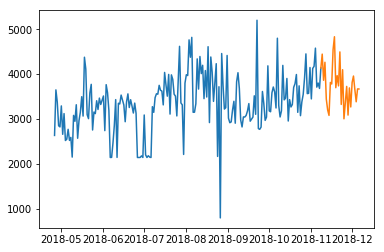

In [47]:
plt.plot(train)
plt.plot(test)
plt.show()

simple average model:

In [48]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()

In [49]:
yhat.tail()

,actual,avg_forecast
date,,
2018-12-02,3957,3352.994924
2018-12-03,3660,3352.994924
2018-12-04,3384,3352.994924
2018-12-05,3670,3352.994924
2018-12-06,3669,3352.994924


ValueError: could not convert string to float: 'Thu'

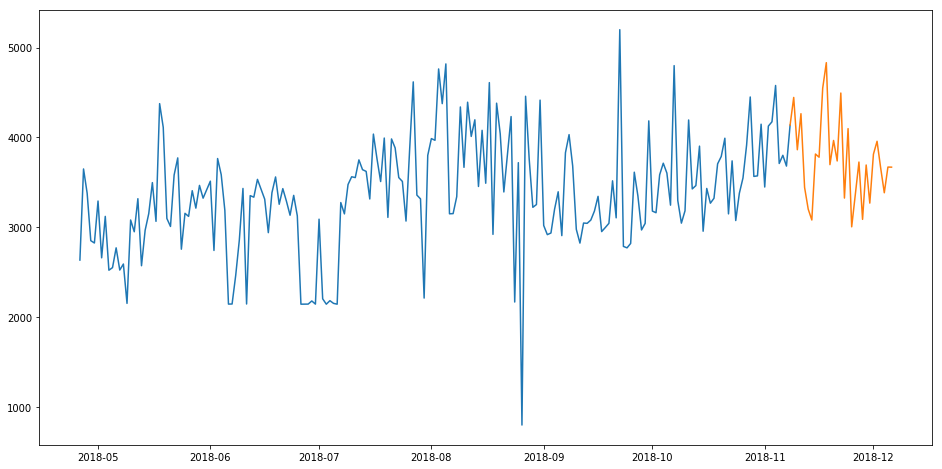

In [50]:
import math
plot_and_eval(yhat.avg_forecast)

In [35]:
periods = 7
yhat['moving_avg_forecast_7'] = train.rolling(7).mean().iloc[-1]

In [51]:
df

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month,day_of_week,is_weekend
date,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,2018,2,4,26,Thu,False
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,2018,2,4,27,Fri,False
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,2018,2,4,28,Sat,True
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,2018,2,4,29,Sun,True
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,2018,2,4,30,Mon,False
2018-05-01,3292,2581,1.22,0,919,167,13,2,1068,2018,2,5,1,Tue,False
2018-05-02,2660,1372,0.65,0,927,90,0,0,419,2018,2,5,2,Wed,False
2018-05-03,3121,2232,1.05,0,876,157,16,0,1006,2018,2,5,3,Thu,False
2018-05-04,2522,904,0.43,1,1012,61,0,0,269,2018,2,5,4,Fri,False


In [36]:
yhat.tail()

,actual,avg_forecast,moving_avg_forecast_7
date,,,
2018-12-02,3957,3352.994924,4029.571429
2018-12-03,3660,3352.994924,4029.571429
2018-12-04,3384,3352.994924,4029.571429
2018-12-05,3670,3352.994924,4029.571429
2018-12-06,3669,3352.994924,4029.571429


In [37]:
float(yhat.moving_avg_forecast_7.max())

4029.5714285714284

ValueError: could not convert string to float: 'Thu'

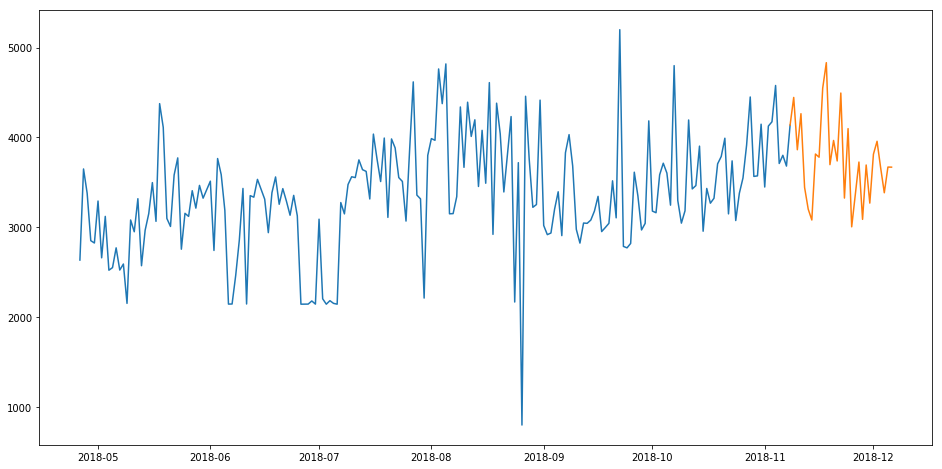

In [38]:
plot_and_eval(yhat.moving_avg_forecast_7)

In [39]:
train = df[:'2018-11-08'].calories_burned.resample('D').agg(aggregation)
test = df['2018-11-08':].calories_burned.resample('D').agg(aggregation)

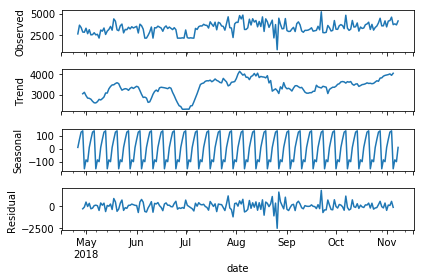

In [40]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [41]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.6, smoothing_slope=.2)

yhat['holt_linear'] = holt.forecast(test.shape[0])

In [42]:
yhat.head()

,actual,avg_forecast,moving_avg_forecast_7,holt_linear
date,,,,
2018-11-08,4137,3352.994924,4029.571429,NaN
2018-11-09,4445,3352.994924,4029.571429,3982.665105
2018-11-10,3863,3352.994924,4029.571429,3993.274173
2018-11-11,4264,3352.994924,4029.571429,4003.883241
2018-11-12,3444,3352.994924,4029.571429,4014.492309


In [43]:
missing_vals = pd.date_range(start='12/07/2018', periods=22)
missing_vals = pd.DataFrame(missing_vals)
missing_vals = missing_vals.rename(columns={0:'date'})

In [63]:
def impute_missing_rolling(df, list):
    missing_vals = pd.date_range(start='12/07/2018', periods=22)
    missing_vals = pd.DataFrame(missing_vals)
    missing_vals = missing_vals.rename(columns={0:'date'})
    for feature in list:
        train = df[:'2018-11-08'][feature].resample('D').agg(aggregation)
        test = df['2018-11-08':][feature].resample('D').agg(aggregation)
        yhat = pd.DataFrame(dict(actual=test))
        yhat['moving_avg_forecast_7'] = train.rolling(7).mean().iloc[-1]
        missing_vals[feature] = float(yhat.moving_avg_forecast_7.max())
    return missing_vals


# def impute_missing_vals(d_df, list):
#     d_df['y'] = df.calories_burned
#     d_df = d_df[['ds', 'y']]
#     d_df['cap'] = 3700
#     d_df['floor'] = 2000
#     m = Prophet(growth='logistic', weekly_seasonality=True)
#     m.fit(d_df)
#     future = m.make_future_dataframe(periods=180)
#     future['cap'] = 3700
#     future['floor'] = 2000
#     forecast = m.predict(future)

#     missing_vals = forecast.loc[225:246][['ds','yhat']]
#     missing_vals.rename(columns={'yhat': 'calories_burned', 'ds': 'date'}, inplace=True)

#     for feature in list:
#         floor = float(df[[feature]].quantile(.05))
#         cap = float(df[[feature]].quantile(.75))
#         d_df['y'] = df[feature]
#         d_df = d_df[['ds', 'y']]
#         d_df['cap'] = cap
#         d_df['floor'] = floor
#         m = Prophet(growth='logistic', weekly_seasonality=True)
#         m.fit(d_df)

#         future = m.make_future_dataframe(periods=180)
#         future['cap'] = cap
#         future['floor'] = floor

#         forecast = m.predict(future)

#         missing_pred = forecast[['yhat']].loc[225:246][['yhat']]

#         missing_pred.rename(columns={'yhat': feature}, inplace=True)
#         missing_vals[feature] = missing_pred[feature]
#     return missing_vals
    

In [64]:
features = []
for col in df:
    features.append(col)
missing_vals = impute_missing_rolling(df, features[:9])


In [65]:
missing_vals

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,2018-12-07,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
1,2018-12-08,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
2,2018-12-09,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
3,2018-12-10,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
4,2018-12-11,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
5,2018-12-12,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
6,2018-12-13,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
7,2018-12-14,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
8,2018-12-15,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286
9,2018-12-16,4029.571429,15651.571429,7.387143,14.571429,616.714286,212.571429,20.571429,88.285714,2272.714286


In [60]:
features = []
for col in df:
    features.append(col)
features

['calories_burned',
 'steps',
 'distance',
 'floors',
 'minutes_sedentary',
 'minutes_lightly_active',
 'minutes_fairly_active',
 'minutes_very_active',
 'activity_calories',
 'year',
 'quarter',
 'month',
 'day_of_month',
 'day_of_week',
 'is_weekend']

In [55]:
missing_vals

,date,calories_burned
0,2018-12-07,4029.571429
1,2018-12-08,4029.571429
2,2018-12-09,4029.571429
3,2018-12-10,4029.571429
4,2018-12-11,4029.571429
5,2018-12-12,4029.571429
6,2018-12-13,4029.571429
7,2018-12-14,4029.571429
8,2018-12-15,4029.571429
9,2018-12-16,4029.571429


In [44]:
yhat = yhat.fillna(4025.410236)

ValueError: could not convert string to float: 'Thu'

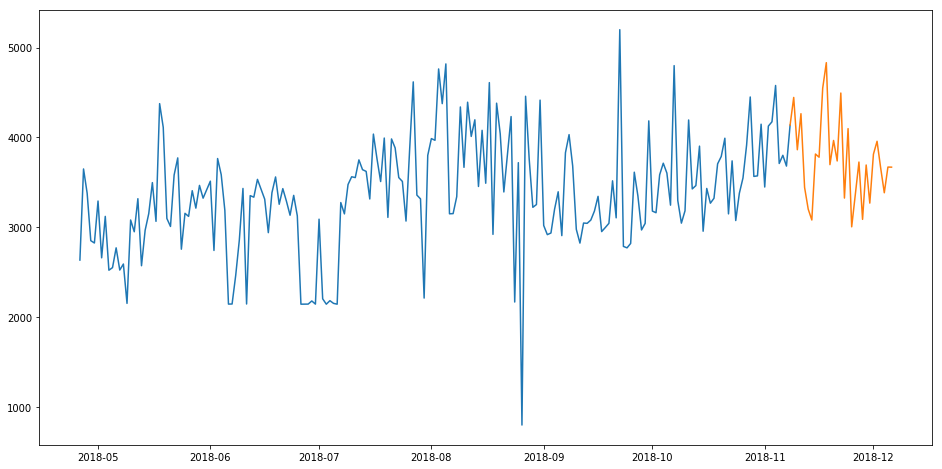

In [45]:
plot_and_eval(yhat.holt_linear)

## Modeling

In [ ]:
train.info()

In [ ]:
test.info()

In [67]:
d_df = df

In [68]:
d_df.head(5)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month,day_of_week,is_weekend
date,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,2018,2,4,26,Thu,False
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,2018,2,4,27,Fri,False
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,2018,2,4,28,Sat,True
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,2018,2,4,29,Sun,True
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,2018,2,4,30,Mon,False


In [69]:
d_df.reset_index(inplace=True)

In [70]:
d_df['y'] = df.calories_burned
d_df['ds'] = pd.to_datetime(d_df.date)
d_df = d_df[['ds', 'y']]

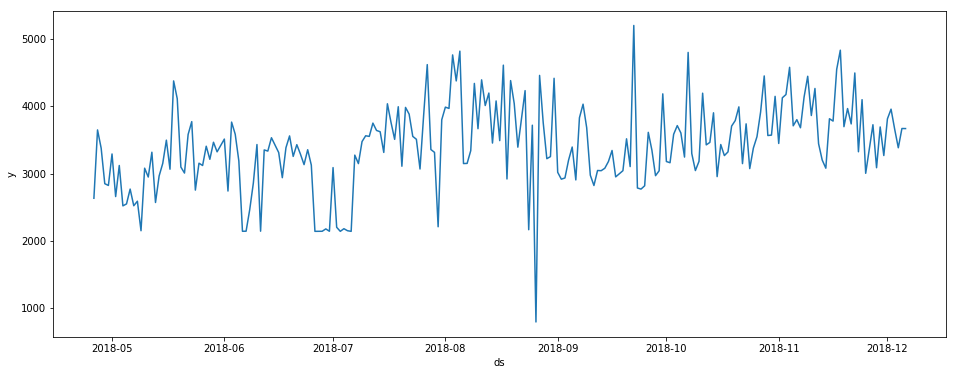

In [71]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [72]:
d_df['cap'] = 4500
d_df['floor'] = 2000

m = Prophet(growth='logistic', weekly_seasonality=True)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
df[['calories_burned']].quantile(.99)

calories_burned    4813.44
Name: 0.99, dtype: float64

In [81]:
future = m.make_future_dataframe(periods=180)
floor = float(df[['calories_burned']].quantile(.05))
cap = float(df[['calories_burned']].quantile(.99))
print(future.head())
print(future.tail())
print(d_df.tail())

          ds
0 2018-04-26
1 2018-04-27
2 2018-04-28
3 2018-04-29
4 2018-04-30
            ds
400 2019-05-31
401 2019-06-01
402 2019-06-02
403 2019-06-03
404 2019-06-04
            ds     y   cap  floor
220 2018-12-02  3957  4500   2000
221 2018-12-03  3660  4500   2000
222 2018-12-04  3384  4500   2000
223 2018-12-05  3670  4500   2000
224 2018-12-06  3669  4500   2000


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)


In [ ]:
fig2 = m.plot_components(forecast)


In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='14 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')


In [ ]:
# need date range 2018-12-07 to 2018-12-28 225-246

In [ ]:
missing_pred = forecast.loc[225:246][['ds','yhat']]

In [ ]:
missing_pred

In [ ]:
missing_pred.rename(columns={'yhat': 'calories_burned', 'ds': 'date'}, inplace=True)

In [ ]:
cal_df = df[['date', 'calories_burned']]

In [ ]:
full_df = cal_df.append(missing_pred)

In [ ]:
full_df

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(full_df.date, full_df.calories_burned)

In [ ]:
df.info()

In [ ]:
features = []
for col in df:
    features.append(col)

In [ ]:
features[2:9]

In [ ]:
d_df.head(5)

In [ ]:


# d_df = df
# d_df.reset_index(inplace=True)
# d_df['ds'] = pd.to_datetime(d_df['date'])

def impute_missing_vals(d_df, list):
    d_df['y'] = df.calories_burned
    d_df = d_df[['ds', 'y']]
    d_df['cap'] = 3700
    d_df['floor'] = 2000
    m = Prophet(growth='logistic', weekly_seasonality=True)
    m.fit(d_df)
    future = m.make_future_dataframe(periods=180)
    future['cap'] = 3700
    future['floor'] = 2000
    forecast = m.predict(future)

    missing_vals = forecast.loc[225:246][['ds','yhat']]
    missing_vals.rename(columns={'yhat': 'calories_burned', 'ds': 'date'}, inplace=True)

    for feature in list:
        floor = float(df[[feature]].quantile(.05))
        cap = float(df[[feature]].quantile(.75))
        d_df['y'] = df[feature]
        d_df = d_df[['ds', 'y']]
        d_df['cap'] = cap
        d_df['floor'] = floor
        m = Prophet(growth='logistic', weekly_seasonality=True)
        m.fit(d_df)

        future = m.make_future_dataframe(periods=180)
        future['cap'] = cap
        future['floor'] = floor

        forecast = m.predict(future)

        missing_pred = forecast[['yhat']].loc[225:246][['yhat']]

        missing_pred.rename(columns={'yhat': feature}, inplace=True)
        missing_vals[feature] = missing_pred[feature]
    return missing_vals
    
    
# cal_df = df[['date', 'calories_burned']]
# full_df = cal_df.append(missing_pred)

In [ ]:
missing_vals = impute_missing_vals(d_df, features[2:9])

In [ ]:
missing_vals

In [ ]:
missing_vals['date'] = pd.to_datetime(missing_vals.date)
missing_vals.set_index('date', inplace=True)

In [ ]:
missing_vals
df[features[:9]].head()

In [ ]:
joined.tail(50)

In [ ]:
missing_vals1 = expand_dt(missing_vals)

In [ ]:
missing_vals_1